In [ ]:
pip install transformers matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

class Plotter:
    def __init__(self):
        self.fig, self.ax = plt.subplots()

    def create_line_plot(self, x, y, title="Line Plot", x_label="X-axis", y_label="Y-axis"):
        self.ax.plot(x, y)
        self.ax.set_title(title)
        self.ax.set_xlabel(x_label)
        self.ax.set_ylabel(y_label)
        plt.show()

    def create_bar_plot(self, x, y, title="Bar Plot", x_label="X-axis", y_label="Y-axis"):
        self.ax.bar(x, y)
        self.ax.set_title(title)
        self.ax.set_xlabel(x_label)
        self.ax.set_ylabel(y_label)
        plt.show()

    def create_scatter_plot(self, x, y, title="Scatter Plot", x_label="X-axis", y_label="Y-axis"):
        self.ax.scatter(x, y)
        self.ax.set_title(title)
        self.ax.set_xlabel(x_label)
        self.ax.set_ylabel(y_label)
        plt.show()


In [ ]:
training_data = [
    {"input": "Create a line plot", "label": "create_line_plot"},
    {"input": "Make a bar chart", "label": "create_bar_plot"},
    {"input": "Generate a scatterplot", "label": "create_scatter_plot"},
    {"input": "Create a scatterplot", "label": "create_scatter_plot"},
    {"input": "Generate a scatter diagram", "label": "create_scatter_plot"},
    {"input": "Make a plot with dots", "label": "create_scatter_plot"},
    {"input": "Create a line graph", "label": "create_line_plot"},
    {"input": "Plot a line with data", "label": "create_line_plot"},
    {"input": "Make a line chart", "label": "create_line_plot"},
    {"input": "Create a bar chart", "label": "create_bar_plot"},
    {"input": "Generate a bar diagram", "label": "create_bar_plot"},
    {"input": "Make a bar graph", "label": "create_bar_plot"},

]


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True
        )
        return {
            "input_ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "label": label,
        }

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Encode labels
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform([example["label"] for example in training_data])

# Create a DataLoader for training data
max_length = 32  # Adjust as needed
train_dataset = CustomDataset(
    texts=[example["input"] for example in training_data],
    labels=training_labels,
    tokenizer=tokenizer,
    max_length=max_length,
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Define and train the intent recognition model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))
optimizer = AdamW(model.parameters(), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    for batch in train_loader:
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            "labels": batch["label"].to(device),
        }
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Save the trained model
model.save_pretrained("intent_model")
tokenizer.save_pretrained("intent_model")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


('intent_model/tokenizer_config.json',
 'intent_model/special_tokens_map.json',
 'intent_model/vocab.txt',
 'intent_model/added_tokens.json')

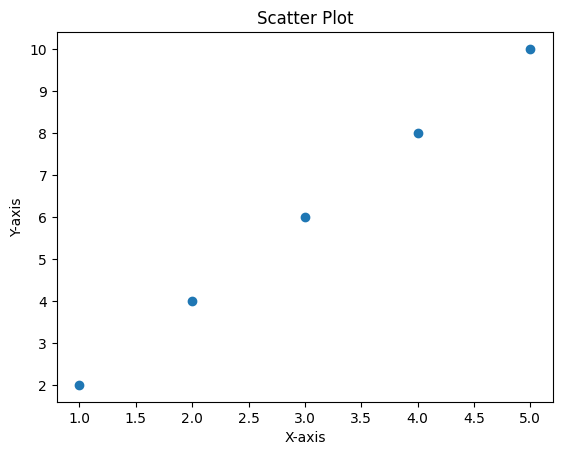

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the trained intent recognition model
model = BertForSequenceClassification.from_pretrained("intent_model")
tokenizer = BertTokenizer.from_pretrained("intent_model")

# User input
user_input = "Create a scatterplot using the values x_data = [1, 2, 3, 4, 5] y_data = [2, 4, 6, 8, 10]"

# Encode the user input
inputs = tokenizer(user_input, return_tensors="pt")

# Perform intent recognition
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

# Decode the predicted label using the label encoder
predicted_function = label_encoder.inverse_transform([predicted_label])[0]

# Initialize the Plotter
plotter = Plotter()

# Process the user input and call the appropriate function
if predicted_function == "create_line_plot":
    plotter.create_line_plot(x_data, y_data)
elif predicted_function == "create_bar_plot":
    plotter.create_bar_plot(x_data, y_data)
elif predicted_function == "create_scatter_plot":
    plotter.create_scatter_plot(x_data, y_data)
else:
    print("Invalid or unrecognized user input")
